# 네이버 검색어 트렌드 복수 단어

참고(네이버 개발자 데이터랩) : https://developers.naver.com/docs/serviceapi/datalab/search/search.md#%ED%86%B5%ED%95%A9-%EA%B2%80%EC%83%89%EC%96%B4-%ED%8A%B8%EB%A0%8C%EB%93%9C

참고2 : B.데이터 수집\01.OpenAPI 데이터 수집\05-카카오_책_검색.ipynb 참고

## #01. 작업 준비

### 패키지

In [1]:
import requests
import json
from pandas import DataFrame, to_datetime, merge, melt

import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

import sys
sys.path.append("../../")
from helper import set_datetime_index, exp_time_data

### 그래프 폰트

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 네이버 검색어 트렌드 OpenAPI 연동

#### 1. API URL

In [3]:
API_URL = "https://openapi.naver.com/v1/datalab/search"

#### 2. 발급 키 인증

In [4]:
client_id = "네이버 개발자 내 애플리케이션에서 확인"
client_secret = "네이버 개발자 내 애플리케이션에서 확인"

### 접속 객체 생성

In [5]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret
    })

### 전달할 검색어 구성

참고 : 네이버 개발자 > Documents > 서비스 > API데이터랩

In [6]:
data = {
    "startDate":"2022-07-01", #2016년 1월 1일부터 조회 시작 가능
    "endDate":"2023-07-01",
    "timeUnit":"date",  #date: 일간, week: 주간, month: 월간
    "keywordGroups":[
        {
            "groupName":"Benz",  #검색주제
            "keywords":["e클래스", "s클래스", "c클래스", "벤츠 cls"]    #주제관련 검색어
        },
        {
            "groupName":"BMW",  #검색주제
            "keywords":["5시리즈", "x5", "x7", "x3"]    #주제관련 검색어
        },
        {
            "groupName":"AUDI",  #검색주제
            "keywords":["a6", "e트론", "a7", "q5"]    #주제관련 검색어
        }
    ]
}

### 데이터 요청

In [8]:
r = session.post(API_URL, data=json.dumps(data))

# 에러 메세지
if r.status_code != 200:
    msg = "[%d Error] %s 에러가 발생함" % (r.status_code, r.reason)
    raise Exception(msg)

# 긁어온 데이터 시각화
r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2022-07-01',
 'endDate': '2023-07-01',
 'timeUnit': 'date',
 'results': [{'title': 'Benz',
   'keywords': ['e클래스', 's클래스', 'c클래스', '벤츠 cls'],
   'data': [{'period': '2022-07-01', 'ratio': 26.82426},
    {'period': '2022-07-02', 'ratio': 28.60838},
    {'period': '2022-07-03', 'ratio': 27.98394},
    {'period': '2022-07-04', 'ratio': 27.69848},
    {'period': '2022-07-05', 'ratio': 28.49241},
    {'period': '2022-07-06', 'ratio': 28.29616},
    {'period': '2022-07-07', 'ratio': 29.34879},
    {'period': '2022-07-08', 'ratio': 28.76003},
    {'period': '2022-07-09', 'ratio': 30.21409},
    {'period': '2022-07-10', 'ratio': 29.66993},
    {'period': '2022-07-11', 'ratio': 30.66904},
    {'period': '2022-07-12', 'ratio': 29.49152},
    {'period': '2022-07-13', 'ratio': 27.69848},
    {'period': '2022-07-14', 'ratio': 29.24174},
    {'period': '2022-07-15', 'ratio': 28.84032},
    {'period': '2022-07-16', 'ratio': 29.87511},
    {'period': '2022-07-17', 'ratio': 30.6958},
   

### 응답 결과 구조

In [9]:
print("검색 결과 수 :", len(mydict['results']))

검색 결과 수 : 3


### DF 생성

In [10]:
# 컬럼을 생성할 검색어 추출
title1 = mydict['results'][0]['title']
# print(title1)

# DF생성-컬럼, 데이터
data = mydict['results'][0]['data']
df1 = DataFrame(data)
df1.rename(columns={"ratio":title1}, inplace=True)
df1.head()

,period,Benz
0,2022-07-01,26.82426
1,2022-07-02,28.60838
2,2022-07-03,27.98394
3,2022-07-04,27.69848
4,2022-07-05,28.49241


In [11]:
title2 = mydict['results'][1]['title']
print(title2)

data = mydict['results'][1]['data']
df2 = DataFrame(data)
df2.rename(columns={'ratio':title2}, inplace=True)
df2.head()

BMW


,period,BMW
0,2022-07-01,38.63514
1,2022-07-02,40.09812
2,2022-07-03,42.46208
3,2022-07-04,41.94469
4,2022-07-05,42.69402


In [12]:
title3 = mydict['results'][2]['title']
print(title2)

data = mydict['results'][2]['data']
df3 = DataFrame(data)
df3.rename(columns={'ratio':title3}, inplace=True)
df3.head()

BMW


,period,AUDI
0,2022-07-01,18.32292
1,2022-07-02,18.50133
2,2022-07-03,19.56289
3,2022-07-04,19.23282
4,2022-07-05,18.73327


### 생성된 DF 병합

merge 참고

C. 데이터 다루기/02. 데이터 전처리/03-행,열_병합.ipynb

D. 탐색적 데이터 분석(EDA)/02. 기술통계/연습문제/연습문제(1)_풀이.ipynb

In [13]:
# 모든 데이터의 교차 병합(합집합)
tmp = merge(df1, df2, how='outer')
df = merge(tmp, df3, how='outer')
df.head()

,period,Benz,BMW,AUDI
0,2022-07-01,26.82426,38.63514,18.32292
1,2022-07-02,28.60838,40.09812,18.50133
2,2022-07-03,27.98394,42.46208,19.56289
3,2022-07-04,27.69848,41.94469,19.23282
4,2022-07-05,28.49241,42.69402,18.73327


## #03. 연동 결과에 대한 시계열 분석

### 데이터 타입 확인

In [14]:
df.dtypes

period     object
Benz      float64
BMW       float64
AUDI      float64
dtype: object

### 날짜 컬럼에 대한 형변환 및 인덱스 설정

In [15]:
df['period'] = to_datetime(df['period'])
df2 = set_datetime_index(df, 'period')
df2

,Benz,BMW,AUDI
2022-07-01,26.82426,38.63514,18.32292
2022-07-02,28.60838,40.09812,18.50133
2022-07-03,27.98394,42.46208,19.56289
2022-07-04,27.69848,41.94469,19.23282
2022-07-05,28.49241,42.69402,18.73327
...,...,...,...
2023-06-27,35.27207,66.12845,18.14451
2023-06-28,36.25334,64.49598,18.24264
2023-06-29,33.48795,61.35593,17.68064
2023-06-30,34.52274,65.22747,17.41302


In [16]:
df3 = df2.reset_index()
df3.head()

,index,Benz,BMW,AUDI
0,2022-07-01,26.82426,38.63514,18.32292
1,2022-07-02,28.60838,40.09812,18.50133
2,2022-07-03,27.98394,42.46208,19.56289
3,2022-07-04,27.69848,41.94469,19.23282
4,2022-07-05,28.49241,42.69402,18.73327


melt 함수 사용 참고

C. 데이터 다루기/02. 데이터 전처리/04-데이터_재구조화.ipynb

D. 탐색적 데이터 분석(EDA)/01. 데이터 시각화/09-서브플롯_예제(전국_지역별_실업률_변화).ipynb

In [17]:
df4 = melt(df3, id_vars=['index'], value_vars=['Benz','BMW','AUDI'], var_name='키워드', value_name='검색량')
df4.set_index('index', inplace=True)
df4

,키워드,검색량
index,,
2022-07-01,Benz,26.82426
2022-07-02,Benz,28.60838
2022-07-03,Benz,27.98394
2022-07-04,Benz,27.69848
2022-07-05,Benz,28.49241
...,...,...
2023-06-27,AUDI,18.14451
2023-06-28,AUDI,18.24264
2023-06-29,AUDI,17.68064


### 검색량 시각화 확인

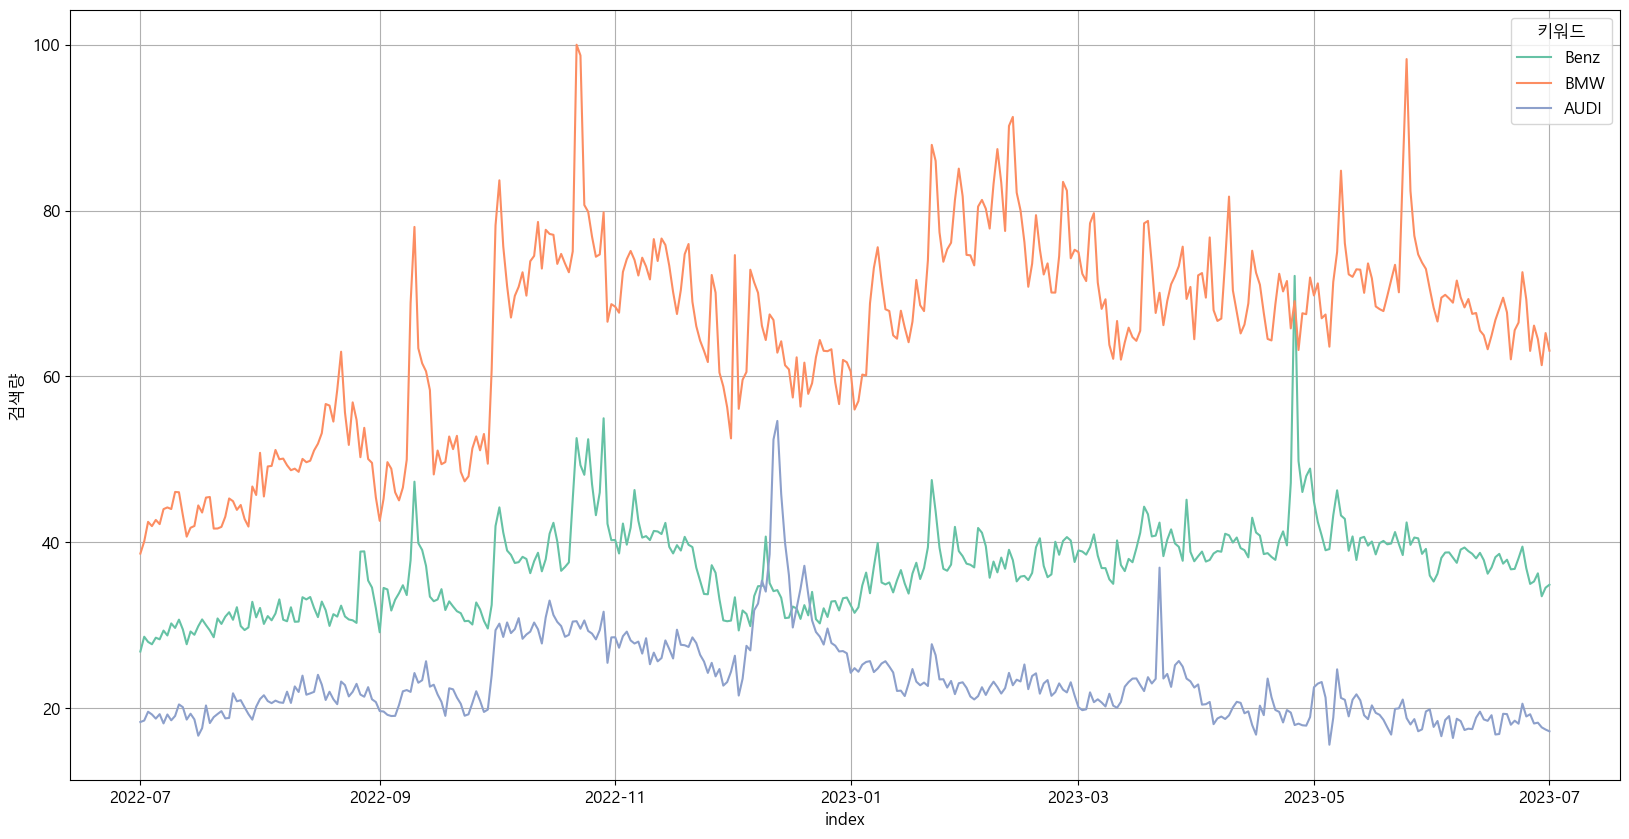

In [18]:
plt.figure(figsize=(20, 10))
sb.lineplot(data=df4, y='검색량', x=df4.index, hue='키워드', palette='Set2')
plt.grid()
plt.show()
plt.close()

### helper에 구현된 기능을 활용하여 데이터 검정

melt 방식으로는 시계열 분석이 진행되지 않음 - melt 데이터를 사용하면 하나의 변수로 분석을 진행해 엉뚱한 결과 값이 도출

xp_time_data에서 "m"으로 한 경우 에러가 나면 데이터에서 0 값이 있다는 의미로 이떄는 "a"로 잡아준다.

데이터가 상승 값이면 곱셈 방식으로 "m". <br/>
데이터가 하강 값이면 덧셈 방식으로 "a". <br/>
max_diff로 최대 차분 횟수 설정. exp_time_data(df, '종속변수', "m", max_diff=최대 차분 횟수)

Benz
결측치 수: 0


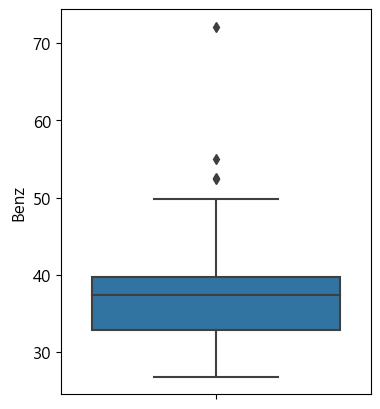

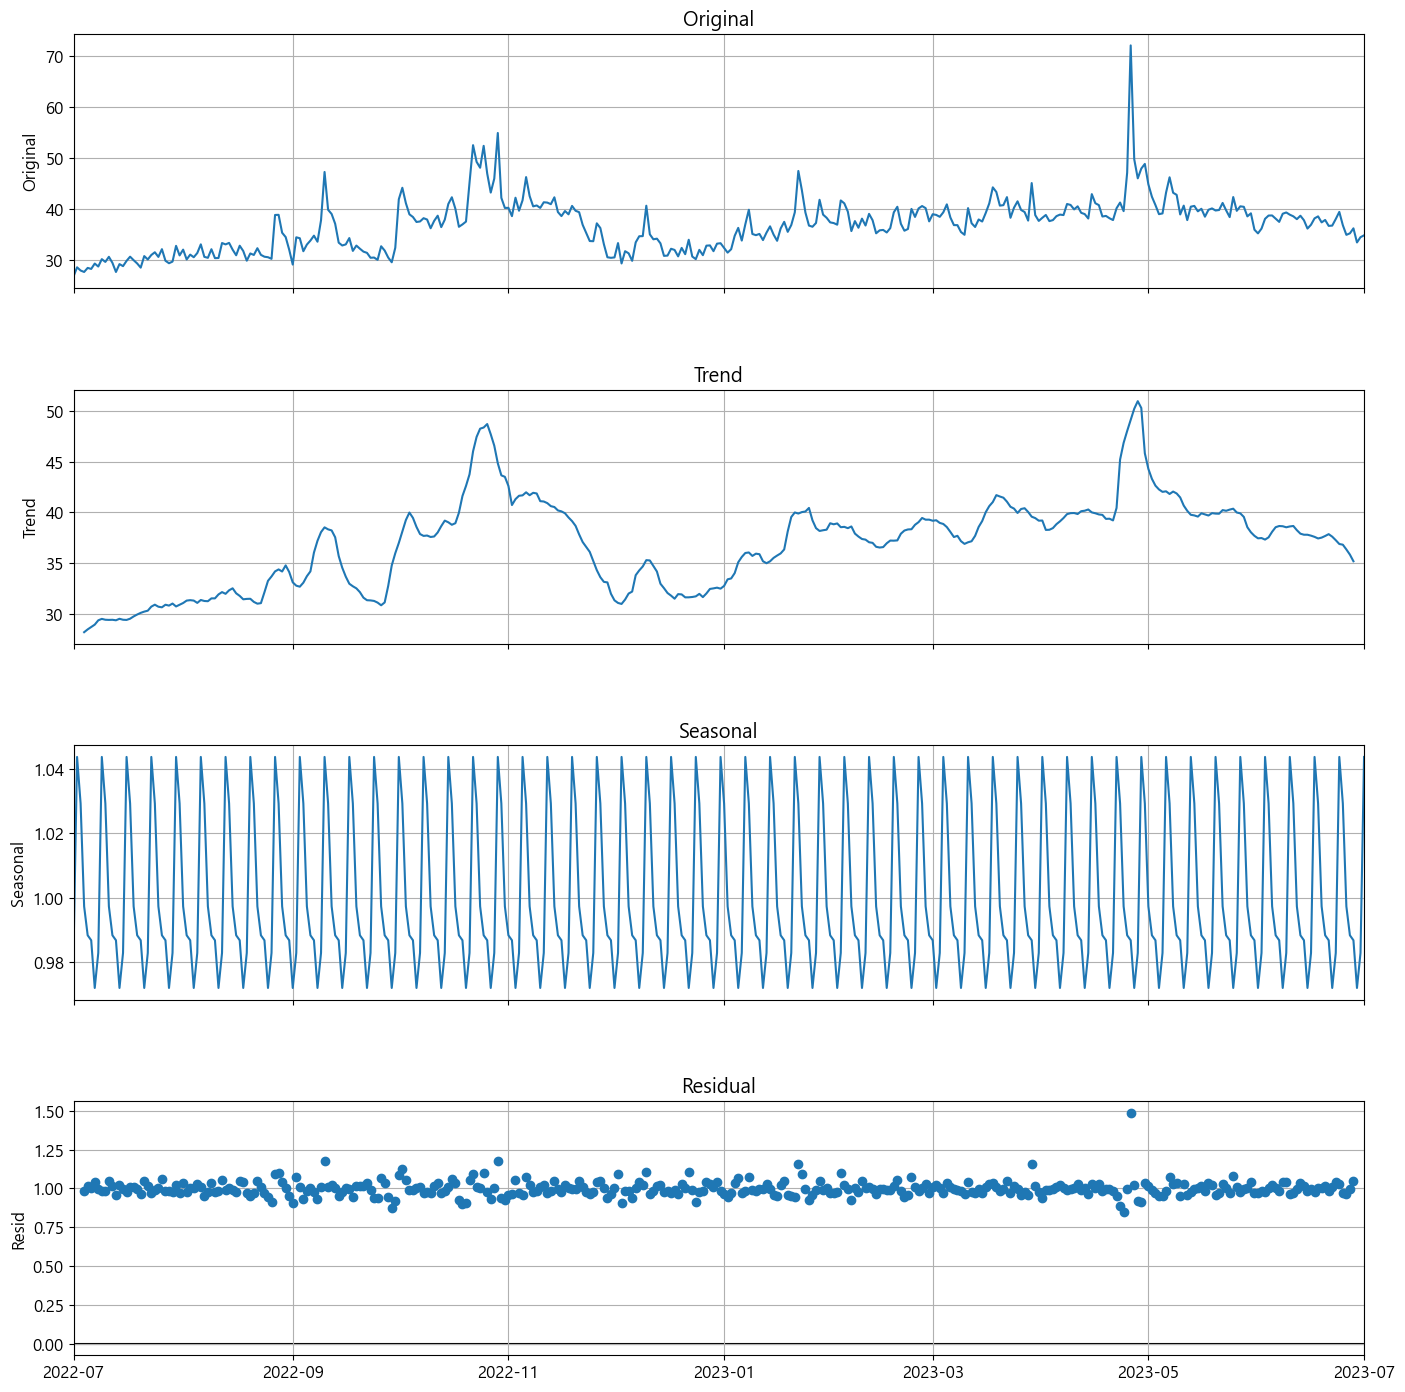

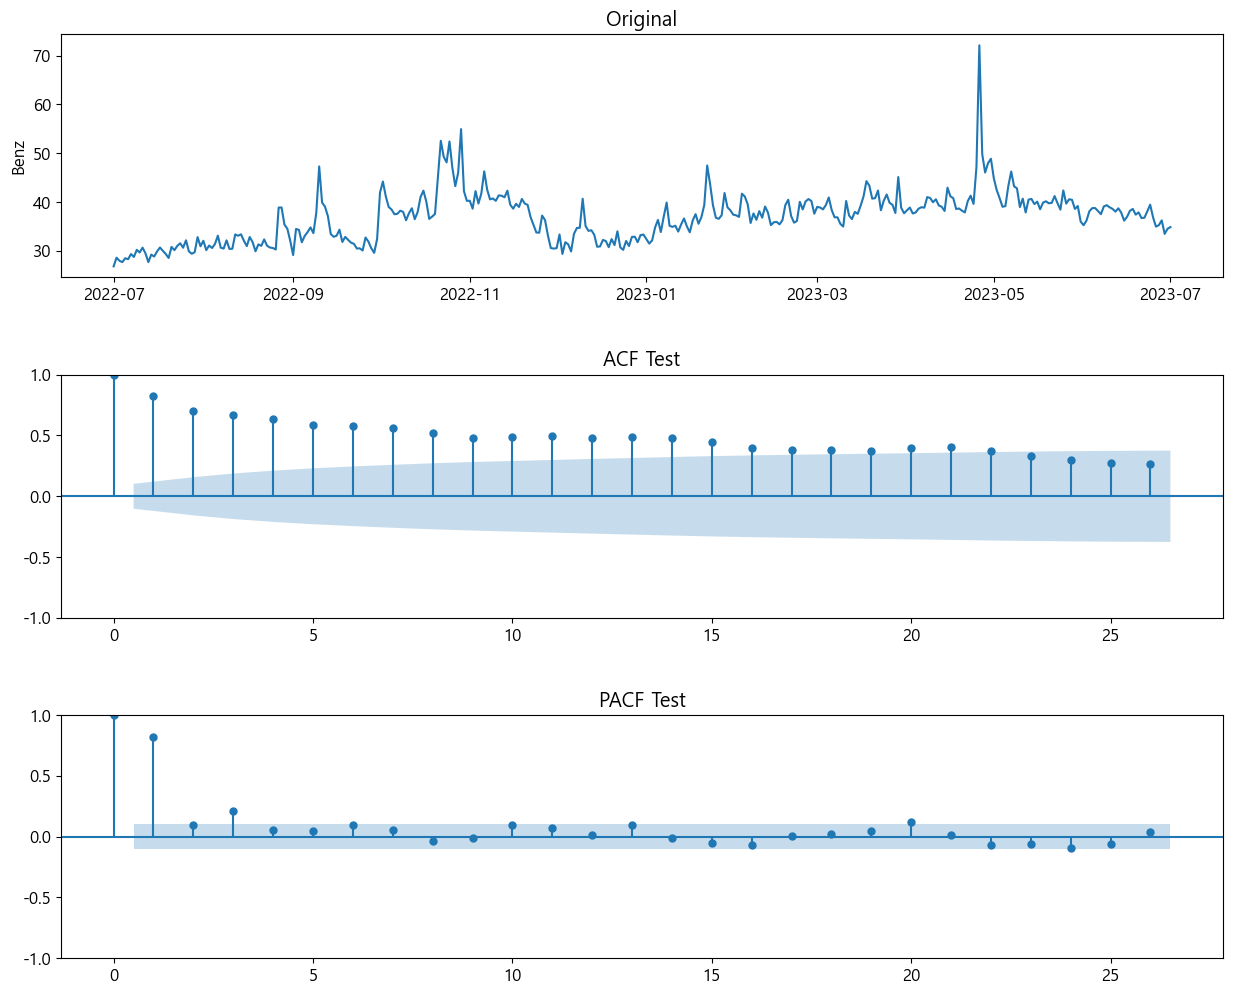

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -4.14114 |
| 유의수준(p-value)                  | 0.000827502 |
| 최적차수(num of lags)              |           2 |
| 관측치 개수(num of observations)   |         363 |
| 기각값(Critical Values) 1%         |    -3.44849 |
| 기각값(Critical Values) 5%         |    -2.86954 |
| 기각값(Critical Values) 10%        |    -2.57103 |
| 데이터 정상성 여부(0=False,1=True) |           1 |
+------------------------------------+-------------+
BMW
결측치 수: 0


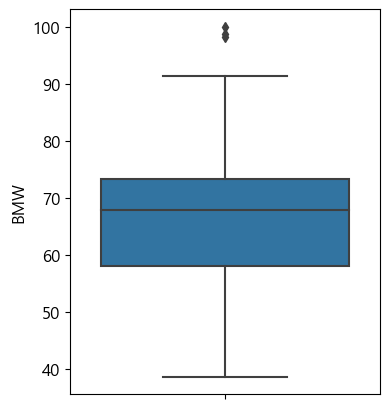

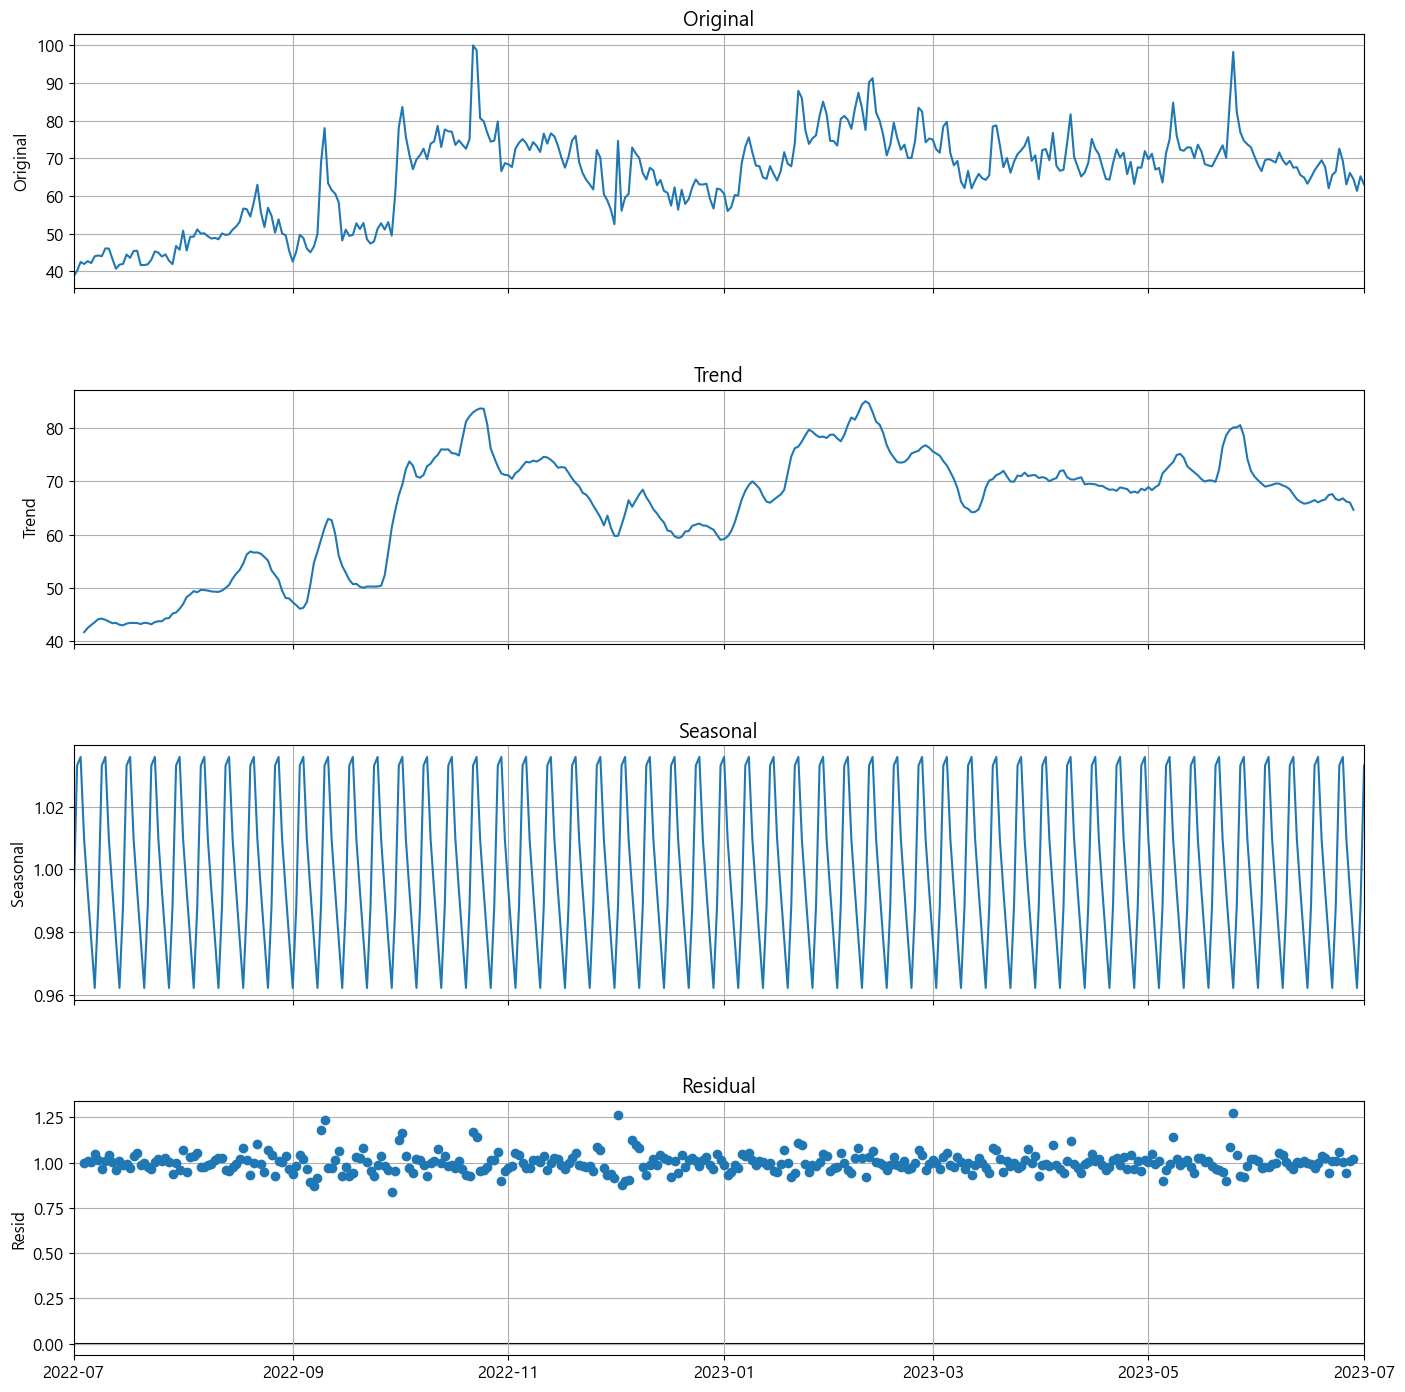

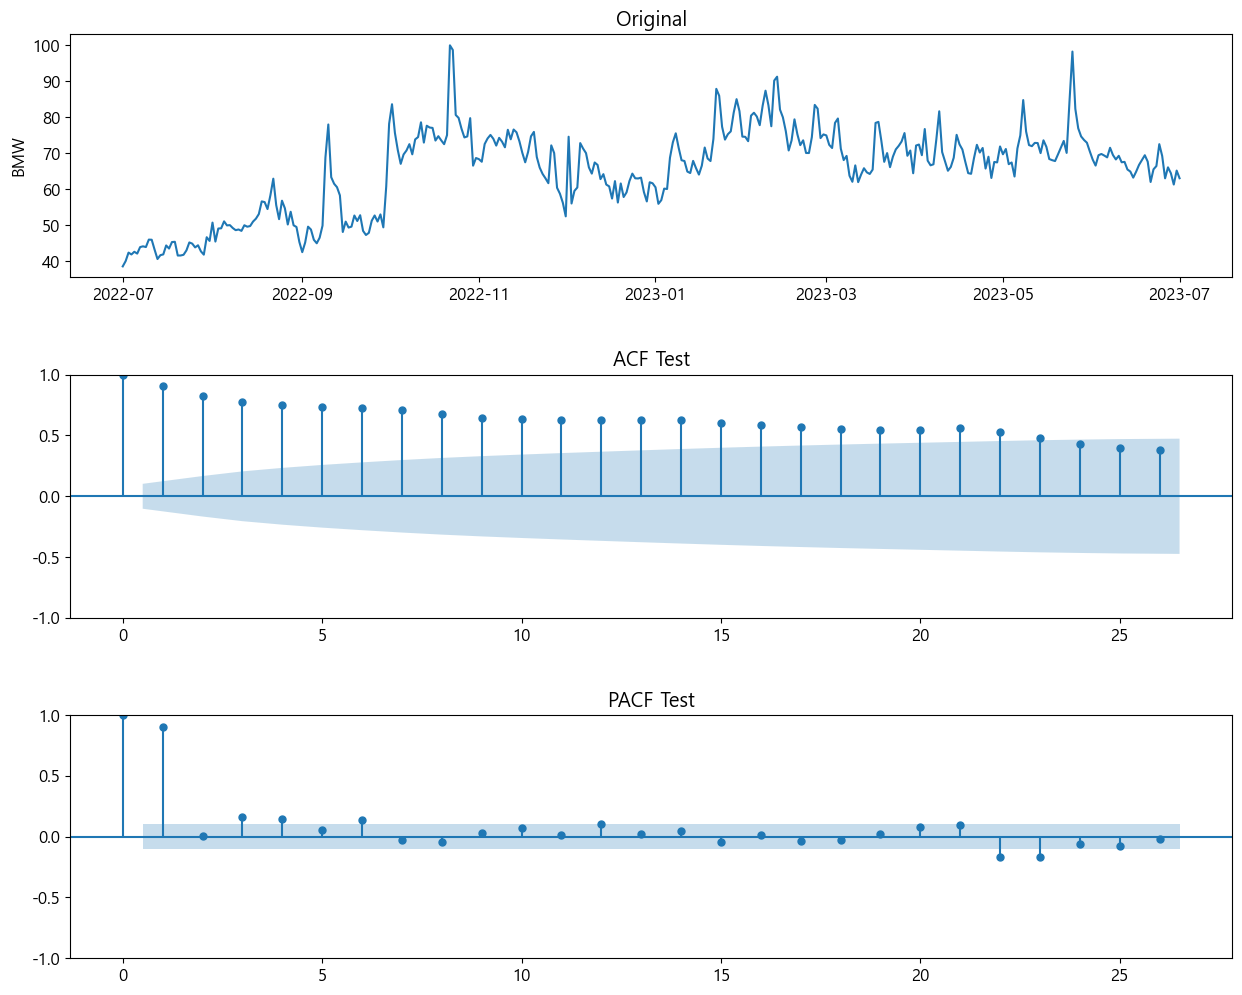

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          |  -2.69884 |
| 유의수준(p-value)                  | 0.0742387 |
| 최적차수(num of lags)              |         5 |
| 관측치 개수(num of observations)   |       360 |
| 기각값(Critical Values) 1%         |  -3.44865 |
| 기각값(Critical Values) 5%         |   -2.8696 |
| 기각값(Critical Values) 10%        |  -2.57107 |
| 데이터 정상성 여부(0=False,1=True) |         0 |
+------------------------------------+-----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -12.6945 |
| 유의수준(p-value)                  | 1.11378e-23 |
| 최적차수(num of lags)              |           4 |
| 관측치 개수(num of observations)   |         360 |
| 기각값

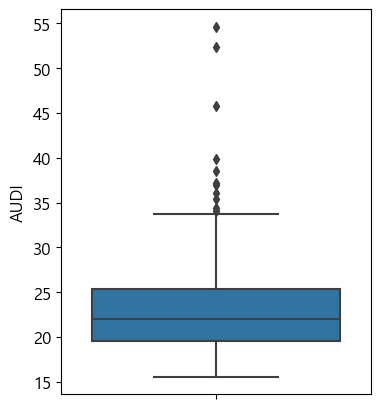

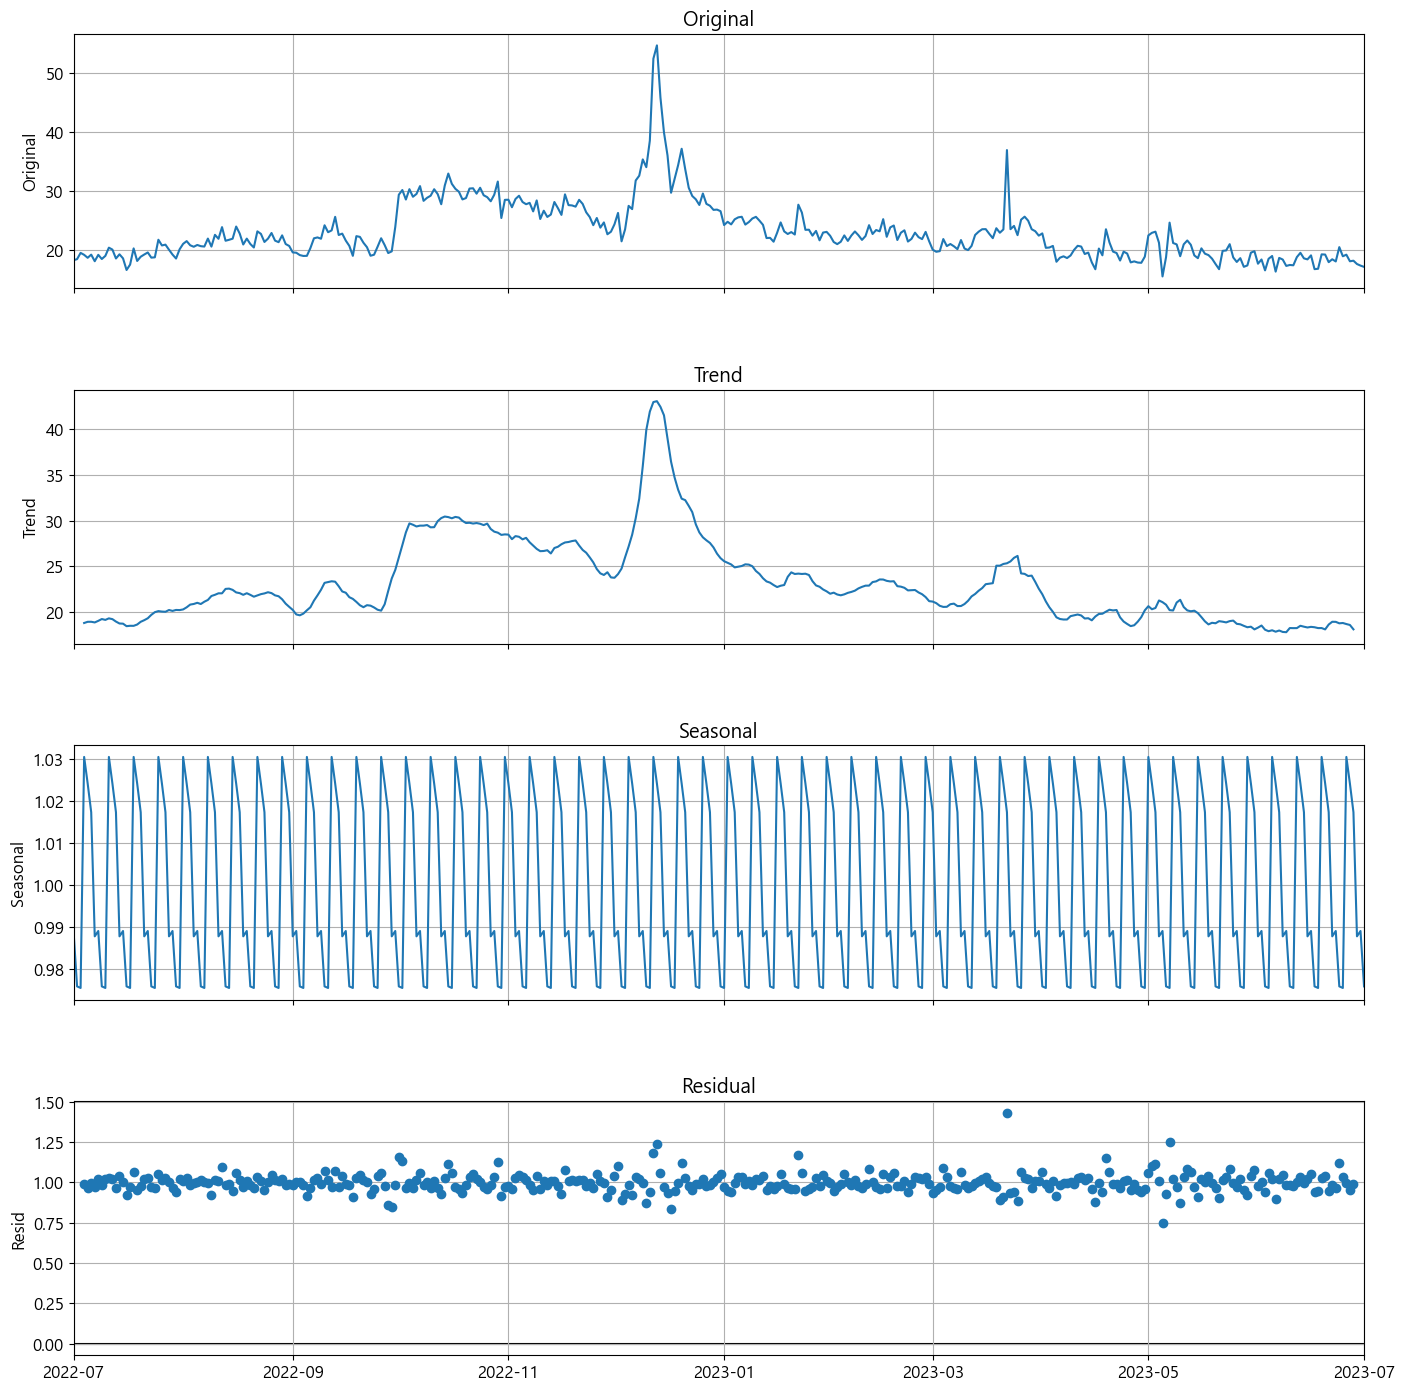

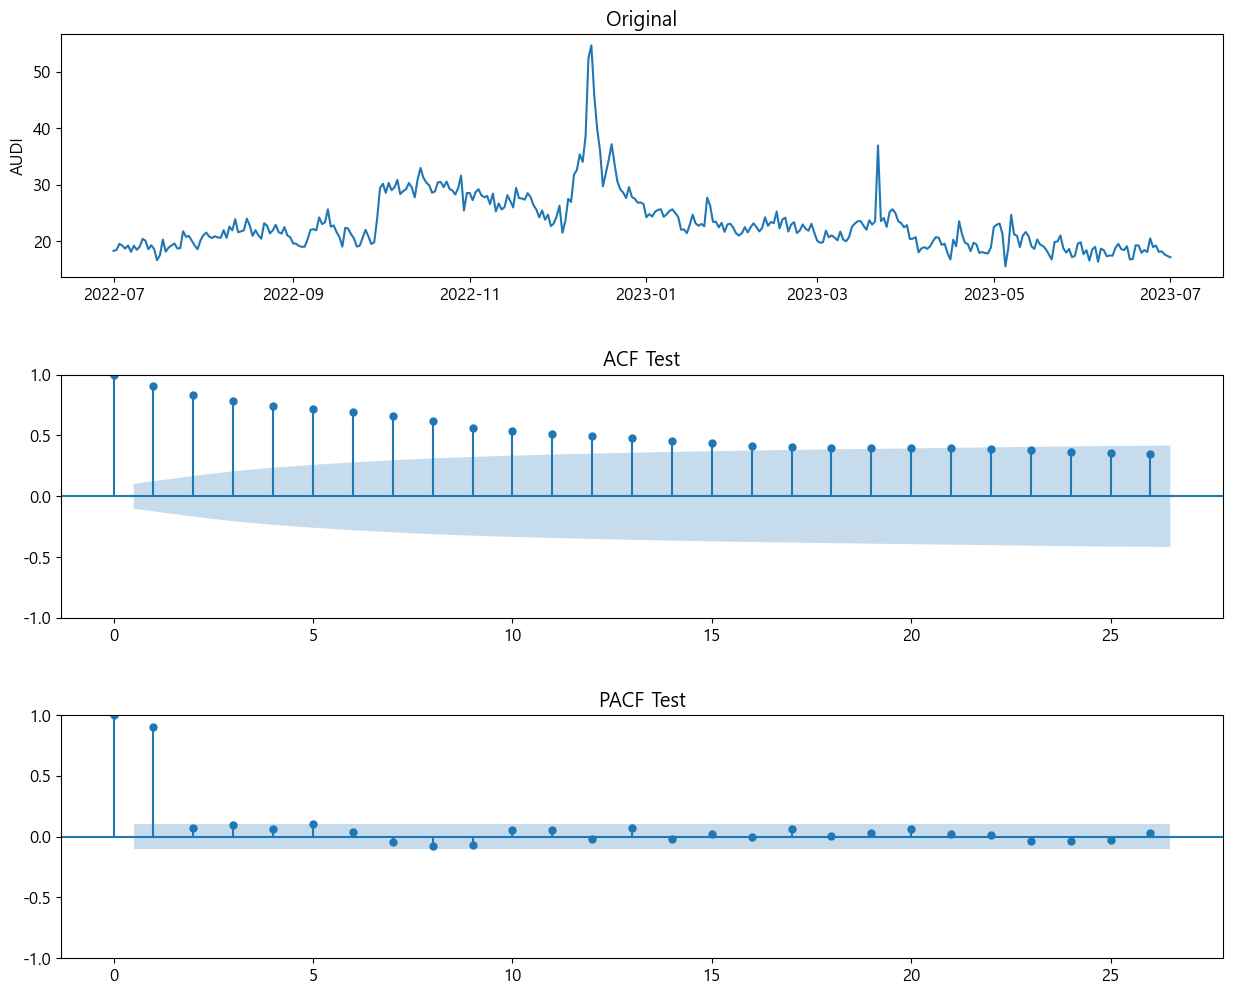

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          |  -2.66285 |
| 유의수준(p-value)                  | 0.0806905 |
| 최적차수(num of lags)              |         4 |
| 관측치 개수(num of observations)   |       361 |
| 기각값(Critical Values) 1%         |  -3.44859 |
| 기각값(Critical Values) 5%         |  -2.86958 |
| 기각값(Critical Values) 10%        |  -2.57105 |
| 데이터 정상성 여부(0=False,1=True) |         0 |
+------------------------------------+-----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -12.4867 |
| 유의수준(p-value)                  | 3.00719e-23 |
| 최적차수(num of lags)              |           3 |
| 관측치 개수(num of observations)   |         361 |
| 기각값

In [19]:
for c in df2.columns:
    print("=========================================")
    print(c)
    print("=========================================")

    exp_time_data(df2, c, "m", max_diff=10)

### ARIMA 분석 수행

#### 분석 모델 구성 1

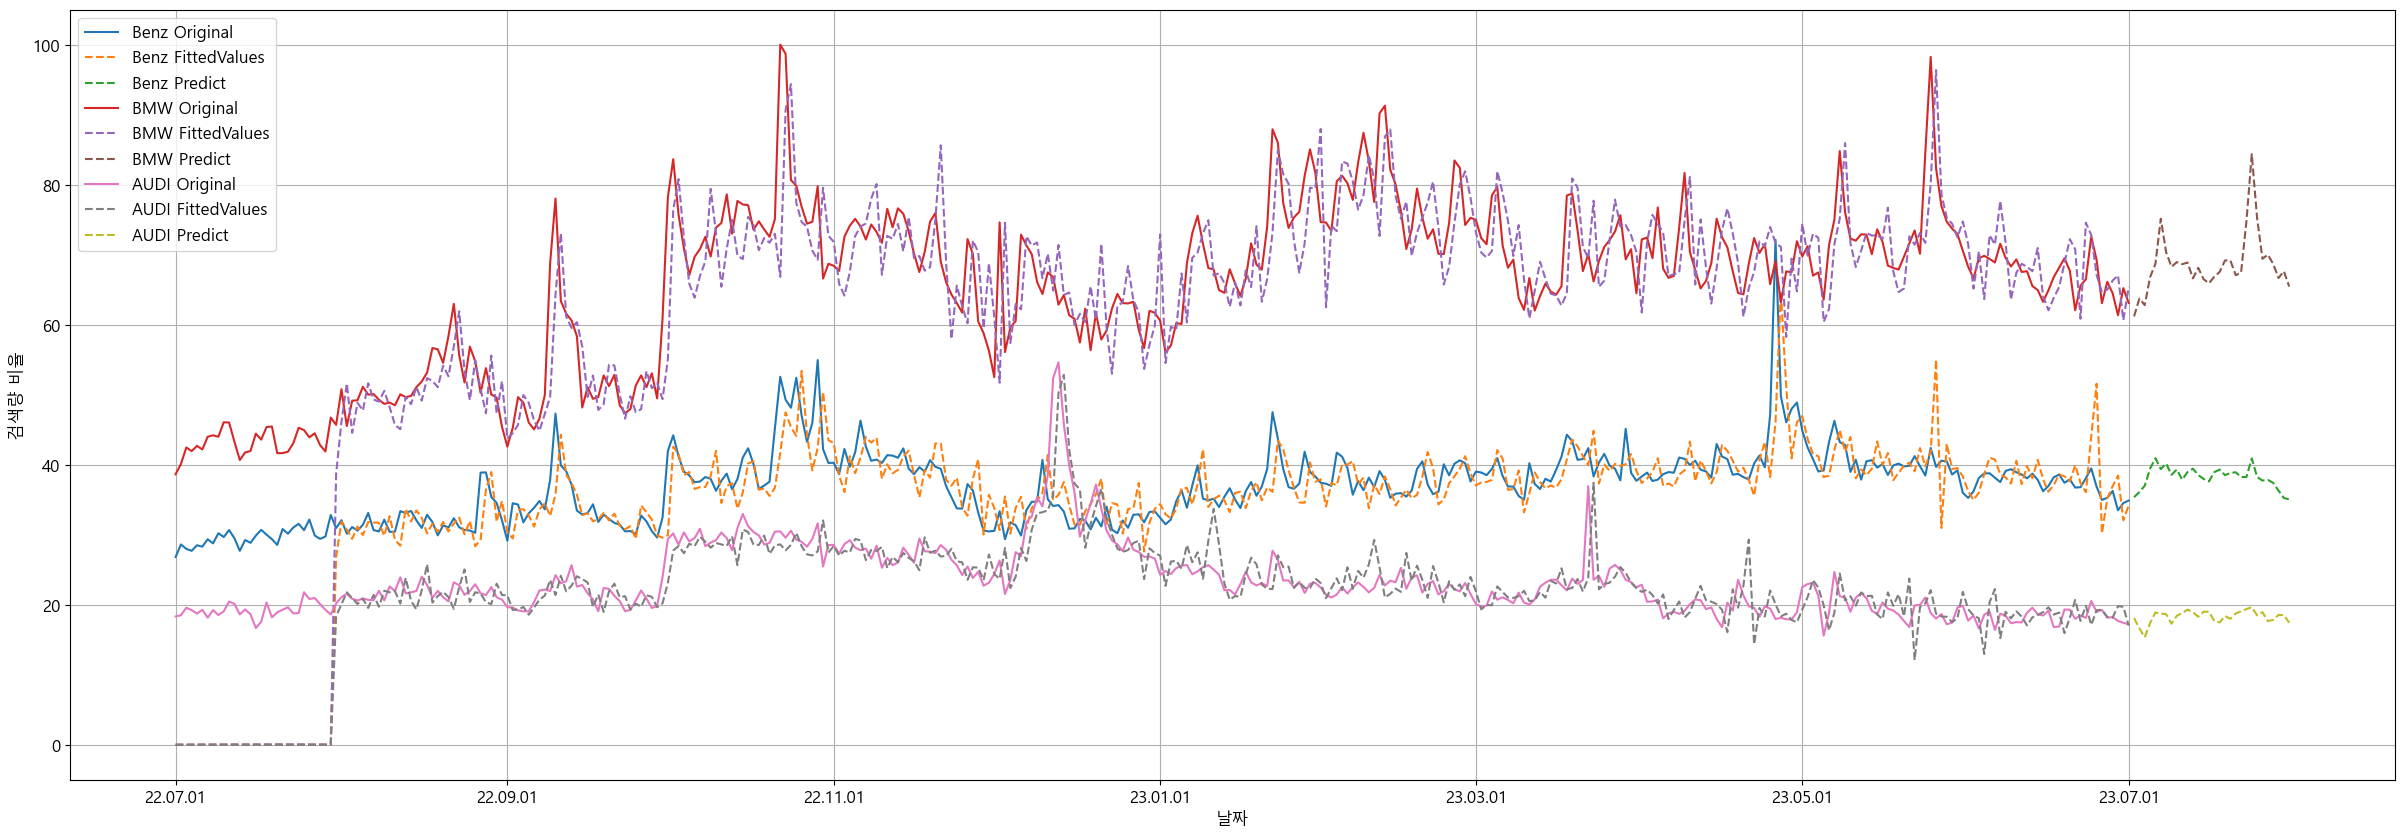

In [20]:
plt.figure(figsize=(30,10))

for c in df2.columns:
    # 모델 구성-계절성은 30으로
    model = ARIMA(df2[c], order=(1,0,0), seasonal_order=(1,1,0,30))
    fit = model.fit()
    # 학습결과
    fv = fit.fittedvalues
    # 향후 30일의 예측값
    fc = fit.forecast(30)
    
    sb.lineplot(data=df2, x=df2.index, y=c, label='%s Original' % c)
    sb.lineplot(x=fv.index, y=fv.values, label='%s FittedValues' % c, linestyle='--')
    sb.lineplot(x=fc.index, y=fc.values, label='%s Predict' % c, linestyle='--')

plt.xlabel('날짜')
plt.ylabel('검색량 비율')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

#### 분석 모델 구성 2

계절성 변경

In [21]:
pdq = (
    ((1,0,0),(1,0,0,7)),    # 0번째
    ((1,1,0),(1,1,0,7)),    # 1번째
    ((1,1,0),(1,1,0,7))     # 2번째
)

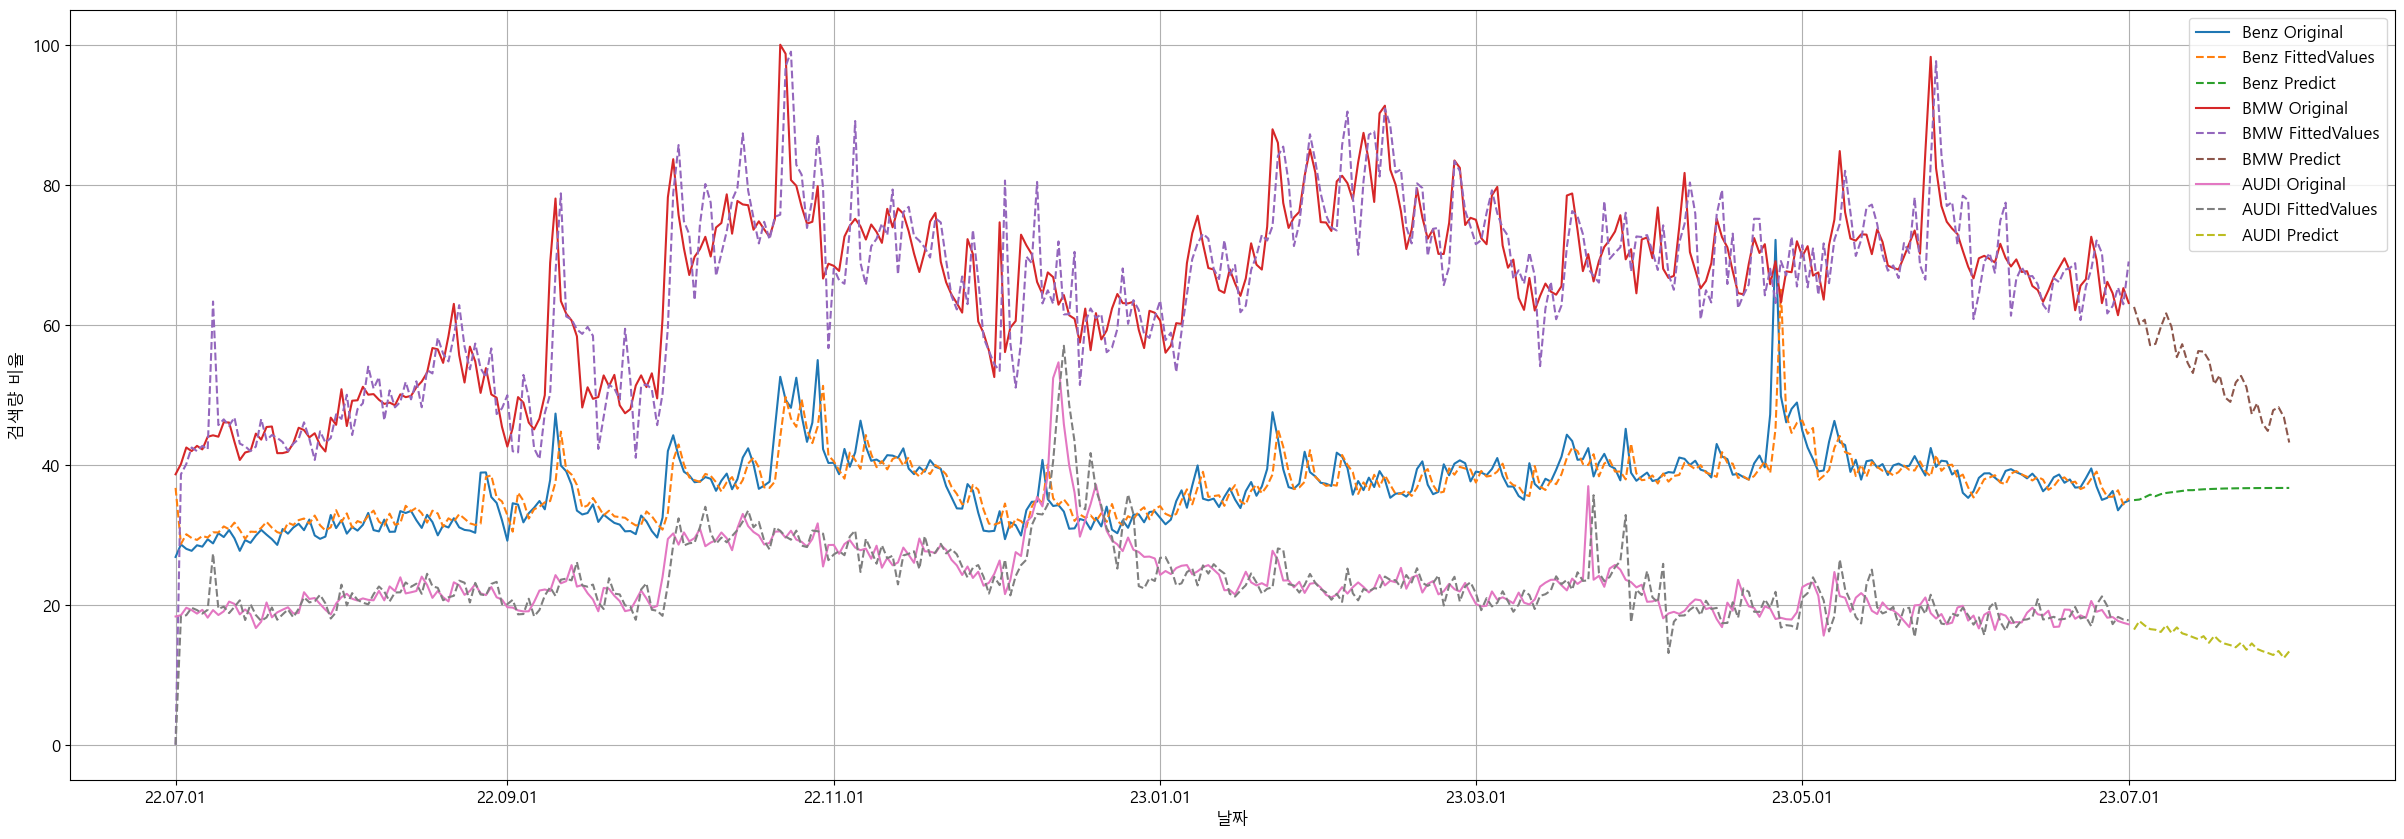

In [22]:
plt.figure(figsize=(30,10))

for i, c in enumerate(df2.columns):
    # 모델 구성
    model = ARIMA(df2[c], order=pdq[i][0], seasonal_order=pdq[i][1])
    fit = model.fit()
    # 학습결과
    fv = fit.fittedvalues
    # 예측값
    fc = fit.forecast(30)
    
    sb.lineplot(data=df2, x=df2.index, y=c, label='%s Original' % c)
    sb.lineplot(x=fv.index, y=fv.values, label='%s FittedValues' % c, linestyle='--')
    sb.lineplot(x=fc.index, y=fc.values, label='%s Predict' % c, linestyle='--')

plt.xlabel('날짜')
plt.ylabel('검색량 비율')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()